0:	learn: 0.2230461	total: 84.3ms	remaining: 15m 27s
1:	learn: 0.2230453	total: 187ms	remaining: 17m 9s
2:	learn: 0.2230442	total: 271ms	remaining: 16m 31s
3:	learn: 0.2230427	total: 365ms	remaining: 16m 44s
4:	learn: 0.2230410	total: 449ms	remaining: 16m 27s
5:	learn: 0.2230394	total: 527ms	remaining: 16m 6s
6:	learn: 0.2230382	total: 626ms	remaining: 16m 22s
7:	learn: 0.2230366	total: 706ms	remaining: 16m 9s
8:	learn: 0.2230355	total: 781ms	remaining: 15m 53s
9:	learn: 0.2230342	total: 858ms	remaining: 15m 42s
10:	learn: 0.2230332	total: 938ms	remaining: 15m 37s
11:	learn: 0.2230320	total: 1.01s	remaining: 15m 29s
12:	learn: 0.2230308	total: 1.1s	remaining: 15m 32s
13:	learn: 0.2230294	total: 1.18s	remaining: 15m 28s
14:	learn: 0.2230281	total: 1.25s	remaining: 15m 18s
15:	learn: 0.2230269	total: 1.34s	remaining: 15m 18s
16:	learn: 0.2230255	total: 1.42s	remaining: 15m 15s
17:	learn: 0.2230244	total: 1.5s	remaining: 15m 13s
18:	learn: 0.2230233	total: 1.57s	remaining: 15m 9s
19:	lear

2024-07-24 20:14:07,626 INFO numerapi.utils: target file already exists
2024-07-24 20:14:07,628 INFO numerapi.utils: download complete
/tmp/ipykernel_150604/3116658174.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_corr = validation.groupby("era").apply(
/tmp/ipykernel_150604/3116658174.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_mmc = validation.dropna().groupby("era").apply(

Time elapsed: 14.0 mins 53.25715732574463 secs


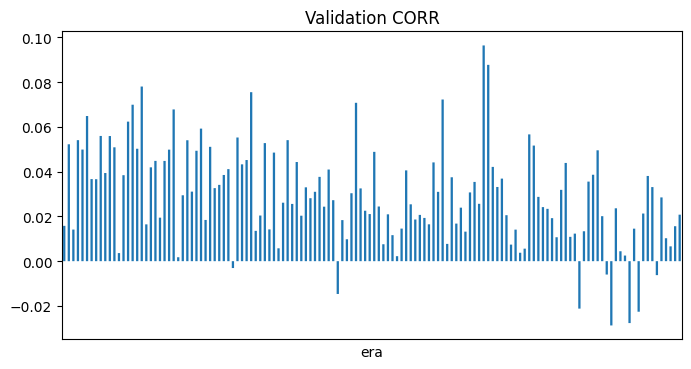

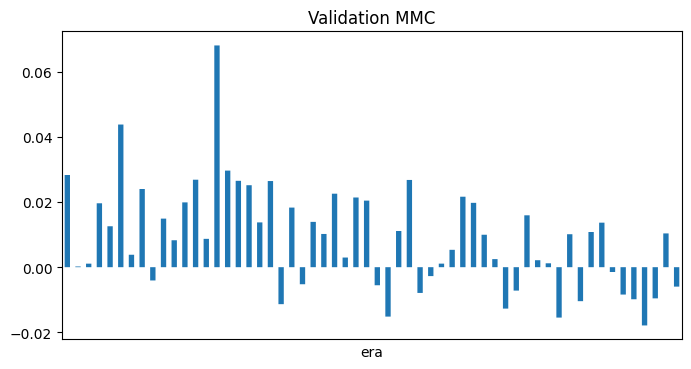

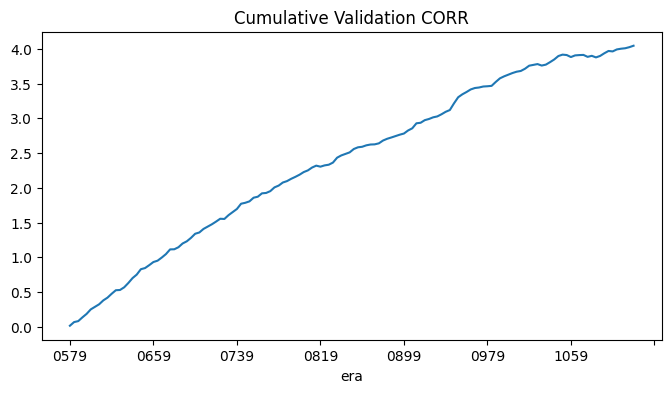

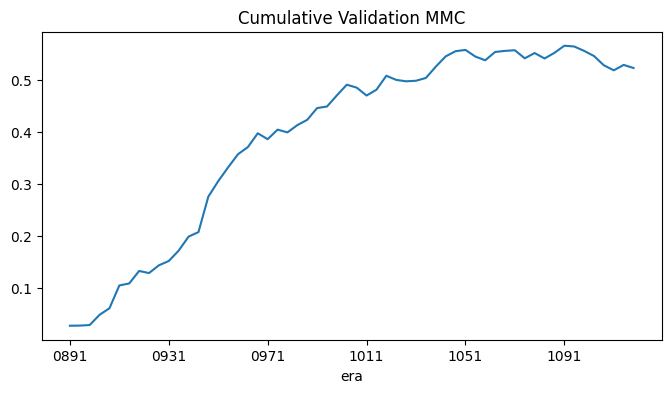

In [16]:
# Initialize NumerAPI - the official Python API client for Numerai
!pip install -q --no-deps numerai-tools

from numerapi import NumerAPI
import json 
import pandas as pd
import time
from catboost import CatBoostRegressor
from numerai_tools.scoring import numerai_corr, correlation_contribution

start_time = time.time()


napi = NumerAPI()

###################################
model_name = 'July24_388k'
DATA_VERSION = "v4.3"
###################################


# Feature Stuff
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]
feature_set = feature_sets["all"]


# Preparing Training Data
train = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + feature_set
)

# train = train[train["era"].isin(train["era"].unique()[::4])]


# Defining Model
model = CatBoostRegressor(
  n_estimators= 500000,
  learning_rate= 0.00000388,
  task_type = "GPU",
  depth = 13,
  l2_leaf_reg = 9,
  verbose = False
)

# Training
model.fit(
  train[feature_set],
  train["target"]
)

model.save_model(f'models/{model_name}.txt')





################## VALIDATION ####################



validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)

# validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[feature_set])
validation[["era", "prediction", "target"]]


# Download and join in the meta_model for the validation eras
# napi.download_dataset(f"{DATA_VERSION}/meta_model.parquet")
validation["meta_model"] = pd.read_parquet(
    f"{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]

# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T


# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

#######################################################################


end_time = time.time()
time_elapsed_mins = (end_time - start_time)//60
time_elapsed_secs = (end_time - start_time)%60
print(f"Time elapsed: {time_elapsed_mins} mins {time_elapsed_secs} secs")



In [17]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

,CORR,MMC
mean,prediction 0.029739 dtype: float64,prediction 0.009011 dtype: float64
std,prediction 0.022116 dtype: float64,prediction 0.015904 dtype: float64
sharpe,prediction 1.344653 dtype: float64,prediction 0.566597 dtype: float64
max_drawdown,prediction 0.03984 dtype: float64,prediction 0.047168 dtype: float64


In [19]:
################## LIVE PREDICTION #########################
model = CatBoostRegressor()
model.load_model(f'models/20.txt')

# Download latest live features
napi.download_dataset(f"{DATA_VERSION}/live_int8.parquet")

# Load live features
live_features = pd.read_parquet(f"{DATA_VERSION}/live_int8.parquet", columns=feature_set)

# Generate live predictions
live_predictions = model.predict(live_features[feature_set])

# Format submission
a = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
a.to_csv(f"predictions2/july24_3.csv")

2024-07-24 20:16:41,407 INFO numerapi.utils: target file already exists
2024-07-24 20:16:41,409 INFO numerapi.utils: download complete
